In [19]:
# pip install sentinelhub --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Sentinel-2 Water Detection with Python and the SentinelHub API

This is a Python script that uses the SentinelHub API to detect water in Sentinel-2 satellite images. The script defines an area of interest (AOI) and a time interval, and uses an evalscript to apply the Normalized Difference Water Index (NDWI) to the image. The result is a binary image showing the water and non-water areas in the AOI.

The script also applies the NDWI algorithm to the image and produces a color image that shows the water in blue and non-water areas in black.

The script requires the `sentinelhub` library and API credentials for SentinelHub. The credentials can be obtained by signing up for a free account on the SentinelHub website. The script can be run in a Jupyter notebook or other Python environment.


In [20]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

# Define your SentinelHub API credentials
config = SHConfig()
config.instance_id = '<your-instance-id>'
config.sh_client_id = '<your-client-id>'
config.sh_client_secret = '<your-client-secret>'

# Define the area of interest (AOI) and its coordinates
aoi_wgs84 = BBox(bbox=[32.1902492, -25.5936676, 33.3530354, -24.6554922], crs=CRS.WGS84)

# Convert the AOI to the UTM coordinate reference system
# utm_bbox, utm_crs = GeoUtils.to_utm(aoi_wgs84)
evalscript_water_detection = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "dataMask"],
    output: { bands: 1 }
  }
}

function evaluatePixel(sample) {
  var NDWI = (sample.B03 - sample.B02) / (sample.B03 + sample.B02);
  var water = NDWI > 0.2 && sample.dataMask == 1;
  return [water];
}
"""

# Define the Sentinel-2 image request parameters
request = SentinelHubRequest(
    data_folder='data',
    evalscript=evalscript_water_detection,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-02-01', '2023-02-16')
        )
    ],
    responses=[
               SentinelHubRequest.output_response('default', MimeType.TIFF) #using TIFF
    ],
    bbox=aoi_wgs84,
    size=(512, 512),
    # output_response='default',
    config=config
)

# Make the Sentinel-2 image request
response = request.get_data()


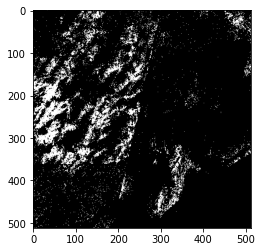

In [21]:

# Plot the requested image
image = np.array(response[0])
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.show()

# Save the image to a file
plt.imsave('output.png', image, cmap=plt.cm.Greys_r)



<ipython-input-22-50b26c00471f>:6: RuntimeWarning: invalid value encountered in true_divide
  return (image[:, :] - image[:, :]) / (image[:, :] + image[:, :])


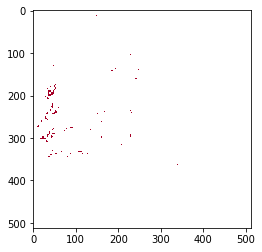

In [22]:
# Define the water detection algorithm (using NDWI)
def ndwi(image):
    """
    Normalized Difference Water Index (NDWI)
    """
    return (image[:, :] - image[:, :]) / (image[:, :] + image[:, :])

# Apply the water detection algorithm to the image
ndwi_image = ndwi(np.array(response[0]))

# Plot the water detection result as a color image
plt.imshow(ndwi_image, cmap=plt.cm.RdYlBu)
plt.show()


# Save the water detection result to a file
plt.imsave('detected_water.png', ndwi_image, cmap=plt.cm.Greys_r)